In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pint
import plotly.express as px
import plotly.graph_objects as go
import xarray as xr
from dask.distributed import Client
from pint import UnitStrippedWarning
from seapopym.configuration.no_transport.parameter import ForcingParameters
from seapopym.configuration.parameters.parameter_forcing import ForcingUnit
from seapopym.standard.units import StandardUnitsLabels

from seapopym_optimization import Observation, constraint, wrapper
from seapopym_optimization.cost_function import NoTransportCostFunction
from seapopym_optimization.functional_groups import FunctionalGroupOptimizeNoTransport, Parameter
from seapopym_optimization.genetic_algorithm import GeneticAlgorithm, GeneticAlgorithmParameters
from seapopym_optimization.taylor_diagram import ModTaylorDiagram, generate_mod_taylor_diagram

warnings.simplefilter("ignore", category=UnitStrippedWarning)
xr.set_options(
    display_expand_attrs=False,
    display_expand_data_vars=False,
    display_expand_coords=False,
    display_expand_data=False,
)

In [2]:
path_to_forcing = "./forcing.zarr"
path_to_obs_hot = "../../../1_data_processing/1_1_Forcing/products/Hot_obs_zoo_climato_monthly_2002_2015.zarr"
path_to_obs_barents = "../../../1_data_processing/1_1_Forcing/1_optional_extract_barents_sea/zoo_2000_2017.zarr"
export_file_name = "SeapoPym_climato_hot_barents_2_groups"

In [3]:
TIME_START = "2005-01-01"
TIME_END = "2010-01-01"
LATITUDE = 22.75
LONGITUDE = -158
STABILIZATION_DAYS = 90
SAVE = True

## Loading


### Forcing


In [4]:
forcing = xr.open_zarr(path_to_forcing)
forcing = forcing.sel(time=slice(TIME_START, TIME_END))
forcing["temperature"].attrs["units"] = StandardUnitsLabels.temperature.units
forcing.load()

<xarray.Dataset> Size: 424kB
Dimensions:              (depth: 3, latitude: 2, longitude: 2, time: 1827)
Coordinates: (4)
Data variables: (3)

### Epipelagic layer


In [5]:
epi_layer_depth = forcing["pelagic_layer_depth"].sel(depth=0).load()
epi_layer_depth = epi_layer_depth.resample(time="1D").mean()
epi_layer_depth.attrs["units"] = "meter"
epi_layer_depth = epi_layer_depth.pint.quantify()
epi_layer_depth

Magnitude,[[[114.84210764968468 nan] [nan 154.8514838879948]] [[113.10354321928514 nan] [nan 155.16812711459391]] [[114.18750083099961 nan] [nan 155.4294606990115]] ... [[113.9499935505495 nan] [nan 152.39512719007502]] [[113.55127089450652 nan] [nan 152.72394211786622]] [[114.84210764968468 nan] [nan 153.024833731158]]]
Units,meter


<!-- ## Observed NPP -->


### Observations


In [6]:
observations_hot = xr.open_zarr(path_to_obs_hot).load()
observations_hot = observations_hot.resample(time="1D").interpolate("linear").dropna("time")
observations_hot = observations_hot.sel(time=slice(TIME_START, TIME_END))
observations_hot = observations_hot.pint.quantify().pint.to("mg/m^3")
observations_hot = observations_hot * epi_layer_depth
observations_hot = observations_hot.drop_vars("depth")
observations_hot = observations_hot[["day", "night"]]
observations_hot

Magnitude,[[[[175.0393382017864]]] [[[171.91155568709888]]] [[[173.07662716509964]]] ... [[[174.86090174350818]]] [[[173.55167845591396]]] [[[175.0393382017864]]]]
Units,milligram/meter2
Magnitude,[[[[296.67369635689136]]] [[[290.87722330653037]]] [[[292.3472049493092]]] ... [[[297.288307051414]]] [[[294.6494292157888]]] [[[296.67369635689136]]]]
Units,milligram/meter2


In [7]:
observations_barents = xr.open_zarr(path_to_obs_barents).load()
observations_barents = observations_barents.resample(time="1D").interpolate("linear").dropna("time")
observations_barents = observations_barents.sel(time=slice(TIME_START, TIME_END))
observations_barents = observations_barents.pint.quantify().pint.to("mg/m^2").pint.dequantify()
observations_barents

<xarray.Dataset> Size: 29kB
Dimensions:    (time: 1827, latitude: 1, longitude: 1, layer: 1)
Coordinates: (4)
Data variables: (1)

Remove the X first months to let the model reach the stationary state.


In [8]:
decay = pd.Timestamp(TIME_START) + pd.Timedelta(days=STABILIZATION_DAYS)

observations_hot = observations_hot.sel(time=slice(str(decay), None))
observations_barents = observations_barents.sel(time=slice(str(decay), None))

Create structure for SeapoPym simulation.


In [9]:
forcing_parameters = ForcingParameters(
    temperature=ForcingUnit(forcing=forcing["temperature"], resolution=1 / 12, timestep=1),
    primary_production=ForcingUnit(forcing=forcing["primary_production"], resolution=1 / 12, timestep=1),
)

2025-01-31 16:32:24,861 :: Seapodym ::  WARNING ::
|	primary_production unit is milligram / day / meter ** 2, it will be converted to kilogram / day / meter ** 2.



## Setup the parameters and the cost function


In [10]:
functional_groups = [
    FunctionalGroupOptimizeNoTransport(
        name="D1N1",
        day_layer=0,
        night_layer=0,
        energy_coefficient=Parameter("D1N1_energy_coefficient", 0.001, 0.5),
        tr_rate=Parameter("D1N1_tr_rate", -0.3, -0.001),
        tr_max=Parameter("D1N1_tr_max", 0, 100),
        inv_lambda_rate=Parameter("D1N1_inv_lambda_rate", -0.3, -0.001),
        inv_lambda_max=Parameter("D1N1_inv_lambda_max", 100, 200),
    ),
    FunctionalGroupOptimizeNoTransport(
        name="D2N1",
        day_layer=1,
        night_layer=0,
        energy_coefficient=Parameter("D2N1_energy_coefficient", 0.001, 0.5),
        tr_rate=Parameter("D2N1_tr_rate", -0.3, -0.001),
        tr_max=Parameter("D2N1_tr_max", 0, 100),
        inv_lambda_rate=Parameter("D2N1_inv_lambda_rate", -0.3, -0.001),
        inv_lambda_max=Parameter("D2N1_inv_lambda_max", 100, 200),
    ),
]

In [11]:
cost_function = NoTransportCostFunction(
    functional_groups=functional_groups,
    forcing_parameters=forcing_parameters,
    observations=[Observation(observations_hot), Observation(observations_barents)],
    standardize_rmse=True,
)

Set the genetic algorithm meta parameters.


In [12]:
genetic_algo_parameters = GeneticAlgorithmParameters(
    MUTPB=0.15,
    INDPB=0.1,
    ETA=5,
    CXPB=0.7,
    NGEN=20,
    POP_SIZE=1000,
    cost_function_weight=(-0.5, -0.5),
)

Add a constraint to limit the total of energy transfert coefficient to 100%.


In [13]:
constraint_energy = constraint.ConstraintNoTransportEnergyCoefficient(
    parameters_name=["D1N1_energy_coefficient", "D2N1_energy_coefficient"],
    min_energy_coef_value=0,
    max_energy_coef_value=1,
)

Finaly, create the Genetic Algorithm.


In [14]:
client = Client()
genetic_algo = GeneticAlgorithm(
    cost_function=cost_function,
    parameter_genetic_algorithm=genetic_algo_parameters,
    constraint=[constraint_energy],
    client=client,
)

/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 55169 instead
  warnings.warn(


And watch the magic on the Dask dashboard :


In [15]:
genetic_algo.client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:55169/status,
Dashboard: http://127.0.0.1:55169/status,Workers: 4
Total threads: 12,Total memory: 48.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:55170,Workers: 4
Dashboard: http://127.0.0.1:55169/status,Total threads: 12
Started: Just now,Total memory: 48.00 GiB
Comm: tcp://127.0.0.1:55184,Total threads: 3
Dashboard: http://127.0.0.1:55186/status,Memory: 12.00 GiB
Nanny: tcp://127.0.0.1:55173,


## Run the optimization


In [16]:
viewer = genetic_algo.optimize()

,mean,std,min,max,valid,from_previous_generation
generation,,,,,,
0,-505.662382,1308.710166,-20208.210788,-0.239910,1000,0.000
1,-55.551147,257.242972,-3332.521495,-0.239910,1000,0.222
2,-6.428868,62.027036,-1878.934316,-0.239910,1000,0.285
3,-5.412578,49.418713,-1423.502043,-0.221092,1000,0.243
4,-9.203866,139.525127,-4324.493371,-0.200941,1000,0.263
5,-4.733670,47.701837,-1473.395751,-0.200941,1000,0.236
6,-5.209956,26.911559,-429.083638,-0.197852,1000,0.268
7,-6.180849,34.439492,-734.631978,-0.200941,1000,0.252
8,-9.908124,71.641781,-1676.152721,-0.229793,1000,0.249


Generations: 100%|██████████| 20/20 [27:32<00:00, 82.64s/it]


## Optimization statistics


In [17]:
viewer.hall_of_fame

D1N1_energy_coefficient  D1N1_tr_max  D1N1_tr_rate  \
generation individual                                                       
10         34                         0.103028    18.600414     -0.171195   
14         114                        0.096499    75.657169     -0.187297   
6          231                        0.103028    18.600414     -0.171195   
12         610                        0.103028    41.326493     -0.171195   
15         415                        0.095454    40.237873     -0.001013   
...                                        ...          ...           ...   
0          131                        0.499885    88.998024     -0.136952   
           892                        0.434742    13.834728     -0.041027   
           671                        0.496482    84.597417     -0.183781   
           429                        0.297620    83.434819     -0.281228   
           305                        0.468339    50.365749     -0.072116   

                       D1N1_inv_lambda_max  D1N1_inv_lambda_rate  \
generation individual                                              
10         34                   194.750371             -0.147979   
14         114                  193.320589             -0.140207   
6          231                  102.746879             -0.113006   
12         610                  194.750371             -0.147979   
15         415                  192.924741             -0.142265   
...                                    ...                   ...   
0          131                  156.005579             -0.008555   
           892                  180.170939             -0.007656   
           671                  196.933867             -0.021245   
           429                  195.250910             -0.016136   
           305                  187.730029             -0.003879   

                       D2N1_energy_coefficient  D2N1_tr_max  D2N1_tr_rate  \
generation individual                                                       
10         34                         0.216093     4.653863     -0.271738   
14         114                        0.286909    21.017117     -0.240136   
6          231                        0.267811    30.721528     -0.274076   
12         610                        0.286909    18.282015     -0.226431   
15         415                        0.383232    18.282015     -0.226431   
...                                        ...          ...           ...   
0          131                        0.464192    77.810633     -0.296608   
           892                        0.128501     1.536304     -0.265175   
           671                        0.412386    19.270872     -0.092590   
           429                        0.467757    81.454314     -0.213085   
           305                        0.435823    90.402534     -0.141691   

                       D2N1_inv_lambda_max  D2N1_inv_lambda_rate       fitness  
generation individual                                                           
10         34                   126.829059             -0.288753      0.197324  
14         114                  121.242137             -0.288753      0.197349  
6          231                  134.622722             -0.281667      0.197852  
12         610                  121.242137             -0.288753      0.197891  
15         415                  121.242137             -0.298810      0.198173  
...                                    ...                   ...           ...  
0          131                  193.663355             -0.296436   9042.043231  
           892                  148.321326             -0.226324   9233.580651  
           671                  191.401968             -0.099848   9430.527243  
           429                  120.648167             -0.004995  10384.592742  
           305                  115.912369             -0.022524  20208.210788  

[15269 rows x 11 columns]

In [18]:
viewer.fitness_evolution()

In [19]:
viewer.box_plot(3, nbest=1000)

In [20]:
groups = [
    ["D1N1_energy_coefficient", "D1N1_tr_rate", "D1N1_tr_max", "D1N1_inv_lambda_rate", "D1N1_inv_lambda_max"],
    ["D2N1_energy_coefficient", "D2N1_tr_rate", "D2N1_tr_max", "D2N1_inv_lambda_rate", "D2N1_inv_lambda_max"],
]
fig = viewer.parallel_coordinates(
    nbest=1000,
    unselected_opacity=0,
    parameter_groups=groups,
)

In [21]:
for trace in fig:
    display(trace)

In [22]:
if SAVE:
    for i, trace in enumerate(fig):
        trace.write_html(f"Parallel_coordinates_{export_file_name}_{i}.html")

# Prepare results for ploting


## Run simulation with original parameters


In [42]:
original_config = [[0, 0, 0.1668, 10.38, -0.11, 150, -0.15]]
print(f"Original configuration: {list(original_config[0])}")

Original configuration: [0, 0, 0.1668, 10.38, -0.11, 150, -0.15]


In [43]:
original_model = wrapper.model_generator_no_transport(
    forcing_parameters=forcing_parameters,
    fg_parameters=wrapper.FunctionalGroupGeneratorNoTransport(parameters=original_config, groups_name=["Total"]),
)

original_model.run()

## Run simulation with optimized parameters


In [61]:
viewer.hall_of_fame

D1N1_energy_coefficient  D1N1_tr_max  D1N1_tr_rate  \
generation individual                                                       
10         34                         0.103028    18.600414     -0.171195   
14         114                        0.096499    75.657169     -0.187297   
6          231                        0.103028    18.600414     -0.171195   
12         610                        0.103028    41.326493     -0.171195   
15         415                        0.095454    40.237873     -0.001013   
...                                        ...          ...           ...   
0          131                        0.499885    88.998024     -0.136952   
           892                        0.434742    13.834728     -0.041027   
           671                        0.496482    84.597417     -0.183781   
           429                        0.297620    83.434819     -0.281228   
           305                        0.468339    50.365749     -0.072116   

                       D1N1_inv_lambda_max  D1N1_inv_lambda_rate  \
generation individual                                              
10         34                   194.750371             -0.147979   
14         114                  193.320589             -0.140207   
6          231                  102.746879             -0.113006   
12         610                  194.750371             -0.147979   
15         415                  192.924741             -0.142265   
...                                    ...                   ...   
0          131                  156.005579             -0.008555   
           892                  180.170939             -0.007656   
           671                  196.933867             -0.021245   
           429                  195.250910             -0.016136   
           305                  187.730029             -0.003879   

                       D2N1_energy_coefficient  D2N1_tr_max  D2N1_tr_rate  \
generation individual                                                       
10         34                         0.216093     4.653863     -0.271738   
14         114                        0.286909    21.017117     -0.240136   
6          231                        0.267811    30.721528     -0.274076   
12         610                        0.286909    18.282015     -0.226431   
15         415                        0.383232    18.282015     -0.226431   
...                                        ...          ...           ...   
0          131                        0.464192    77.810633     -0.296608   
           892                        0.128501     1.536304     -0.265175   
           671                        0.412386    19.270872     -0.092590   
           429                        0.467757    81.454314     -0.213085   
           305                        0.435823    90.402534     -0.141691   

                       D2N1_inv_lambda_max  D2N1_inv_lambda_rate       fitness  
generation individual                                                           
10         34                   126.829059             -0.288753      0.197324  
14         114                  121.242137             -0.288753      0.197349  
6          231                  134.622722             -0.281667      0.197852  
12         610                  121.242137             -0.288753      0.197891  
15         415                  121.242137             -0.298810      0.198173  
...                                    ...                   ...           ...  
0          131                  193.663355             -0.296436   9042.043231  
           892                  148.321326             -0.226324   9233.580651  
           671                  191.401968             -0.099848   9430.527243  
           429                  120.648167             -0.004995  10384.592742  
           305                  115.912369             -0.022524  20208.210788  

[15269 rows x 11 columns]

In [44]:
best_individual = cost_function.functional_groups.generate_matrix(viewer.hall_of_fame.iloc[0])
print(f"Best individual: {list(best_individual[0])}")
print(f"Best individual: {list(best_individual[1])}")

Best individual: [0.0, 0.0, 0.10302832129823505, 18.60041444543309, -0.17119533219076244, 194.75037131479465, -0.14797899900888004]
Best individual: [1.0, 0.0, 0.21609259274871612, 4.6538629321475895, -0.2717378678017114, 126.82905937131659, -0.288753078396907]


In [45]:
best_model = wrapper.model_generator_no_transport(
    forcing_parameters=forcing_parameters,
    fg_parameters=wrapper.FunctionalGroupGeneratorNoTransport(parameters=best_individual, groups_name=["D1N1", "D2N1"]),
)

best_model.run()

And with the X best individuals :


In [46]:
NB_INDIVIDUAL_TO_SHOW = 100

min_biomass_D1N1 = (
    best_model.export_biomass().sel(latitude=[LATITUDE], longitude=[LONGITUDE]).sel(functional_group=0).data.flatten()
)
max_biomass_D1N1 = (
    best_model.export_biomass().sel(latitude=[LATITUDE], longitude=[LONGITUDE]).sel(functional_group=0).data.flatten()
)
min_biomass_D2N1 = (
    best_model.export_biomass().sel(latitude=[LATITUDE], longitude=[LONGITUDE]).sel(functional_group=1).data.flatten()
)
max_biomass_D2N1 = (
    best_model.export_biomass().sel(latitude=[LATITUDE], longitude=[LONGITUDE]).sel(functional_group=1).data.flatten()
)

biomass_accumulated = []

for cpt in range(0, NB_INDIVIDUAL_TO_SHOW):
    individual = cost_function.functional_groups.generate_matrix(viewer.hall_of_fame.iloc[cpt])
    model = wrapper.model_generator_no_transport(
        forcing_parameters=forcing_parameters,
        fg_parameters=wrapper.FunctionalGroupGeneratorNoTransport(parameters=individual, groups_name=["D1N1", "D2N1"]),
    )
    model.run()

    biomass_accumulated.append(
        model.export_biomass().sel(latitude=[LATITUDE], longitude=[LONGITUDE]).expand_dims({"individual": [cpt]})
    )

In [47]:
with xr.set_options(keep_attrs=True):
    best_individuals_simulations = xr.concat(biomass_accumulated, dim="individual")
    min_biomass_D1N1 = (
        best_individuals_simulations.sel(functional_group=0).min("individual").isel(latitude=0, longitude=0)
    )
    max_biomass_D1N1 = (
        best_individuals_simulations.sel(functional_group=0).max("individual").isel(latitude=0, longitude=0)
    )
    min_biomass_D2N1 = (
        best_individuals_simulations.sel(functional_group=1).min("individual").isel(latitude=0, longitude=0)
    )
    max_biomass_D2N1 = (
        best_individuals_simulations.sel(functional_group=1).max("individual").isel(latitude=0, longitude=0)
    )

### Format the results


Convert to pandas series.


In [48]:
optimized_biomass_pandas = (
    best_model.export_biomass()
    .sel(latitude=[LATITUDE], longitude=[LONGITUDE])
    .pint.quantify()
    .pint.to("mg/meter^2")
    .pint.dequantify()
    .to_dataframe()
    .pivot_table(index="time", columns="functional_group", values="biomass")
)
original_biomass_pandas = (
    original_model.export_biomass()
    .sel(latitude=[LATITUDE], longitude=[LONGITUDE])
    .pint.quantify()
    .pint.to("mg/meter^2")
    .pint.dequantify()
    .to_dataframe()
    .pivot_table(index="time", columns="functional_group", values="biomass")
)
observations_day_pandas = (
    observations_hot.pint.quantify()
    .pint.to("mg/meter^2")
    .pint.dequantify()
    .day.dropna("time")
    .to_dataframe()
    .reset_index()
    .set_index("time")["day"]
)
observations_night_pandas = (
    observations_hot.pint.quantify()
    .pint.to("mg/meter^2")
    .pint.dequantify()
    .night.dropna("time")
    .to_dataframe()
    .reset_index()
    .set_index("time")["night"]
)
layer_pandas = (
    epi_layer_depth.sel(latitude=[LATITUDE], longitude=[LONGITUDE])
    .pint.dequantify()
    .to_dataframe()
    .reset_index()
    .set_index("time")["pelagic_layer_depth"]
)

Then resample to month.


In [49]:
monthly_obs_day = observations_day_pandas.resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_obs_day.index = monthly_obs_day.index.to_period("M").to_timestamp()

monthly_obs_night = observations_night_pandas.resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_obs_night.index = monthly_obs_night.index.to_period("M").to_timestamp()

monthly_pred_d1n1 = optimized_biomass_pandas.iloc[:, 0].resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_pred_d1n1.index = monthly_pred_d1n1.index.to_period("M").to_timestamp()

monthly_pred_d2n1 = optimized_biomass_pandas.iloc[:, 1].resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_pred_d2n1.index = monthly_pred_d2n1.index.to_period("M").to_timestamp()

monthly_pred_orignal = original_biomass_pandas.iloc[:, 0].resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_pred_orignal.index = monthly_pred_orignal.index.to_period("M").to_timestamp()

monthly_layer = layer_pandas.resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_layer.index = monthly_layer.index.to_period("M").to_timestamp()

# Plot


### Correlation matrix of X best individuals


In [50]:
NB_INDIVIDUAL_CORRELATION = 2000

indiv_param = viewer.hall_of_fame.iloc[:NB_INDIVIDUAL_CORRELATION, :-1].to_numpy()
param_names = viewer.hall_of_fame.columns[:-1]

corr_matrix = np.corrcoef(indiv_param.T)
np.fill_diagonal(corr_matrix, np.nan)

fig = px.imshow(
    corr_matrix,
    text_auto=False,
    aspect="auto",
    color_continuous_scale=[[0, "blue"], [0.5, "white"], [1, "red"]],
    zmin=-1,
    zmax=1,
    x=param_names,
    y=param_names,
)
fig.update_layout(
    title="Correlation Matrix of Hall of Fame Parameters (Lower Triangle)",
    plot_bgcolor="rgba(0,0,0,0)",
    paper_bgcolor="rgba(0,0,0,0)",
    xaxis={"showgrid": False, "tickangle": -35},
    yaxis={"showgrid": False},
)

fig.show()

In [51]:
if SAVE:
    fig.write_html(f"Correlation_best_individuals_{export_file_name}.html")

### Daily with best individuals


In [52]:
x = best_model.export_biomass().sel(latitude=[LATITUDE], longitude=[LONGITUDE]).time.to_series()
x_rev = pd.concat([x, x[::-1]])

fig = go.Figure()

# D1N1 data
y_D1N1 = (
    best_model.export_biomass()
    .sel(latitude=[LATITUDE], longitude=[LONGITUDE])
    .sel(functional_group=0)
    .pint.quantify()
    .pint.to("mg/m2")
    .pint.dequantify()
    .data.flatten()
)
y_D1N1_upper = max_biomass_D1N1.pint.quantify().pint.to("milligram / meter ** 2")
y_D1N1_lower = min_biomass_D1N1.pint.quantify().pint.to("milligram / meter ** 2")[::-1]
y_D1N1_rev = np.concatenate([y_D1N1_upper, y_D1N1_lower])

# D2N1 data
y_D2N1 = (
    best_model.export_biomass()
    .sel(latitude=[LATITUDE], longitude=[LONGITUDE])
    .sel(functional_group=1)
    .pint.quantify()
    .pint.to("mg/m2")
    .pint.dequantify()
    .data.flatten()
) + y_D1N1
y_D2N1_upper = max_biomass_D2N1.pint.quantify().pint.to("milligram / meter ** 2") + y_D1N1_upper
y_D2N1_lower = min_biomass_D2N1.pint.quantify().pint.to("milligram / meter ** 2")[::-1] + y_D1N1_lower
y_D2N1_rev = np.concatenate([y_D2N1_upper, y_D2N1_lower])

fig = go.Figure()

# D1N1 traces
fig.add_trace(
    go.Scatter(
        x=x_rev,
        y=y_D1N1_rev,
        fill="toself",
        fillcolor="rgba(255,0,0,0.2)",
        line_color="rgba(255,255,255,0)",
        name=f"D1N1 : {NB_INDIVIDUAL_TO_SHOW} best individuals",
    )
)

fig.add_trace(
    go.Scatter(
        x=x,
        y=y_D1N1,
        line_color="rgb(255,0,0)",
        name="D1N1 : Best individual",
    )
)

# D2N1 traces
fig.add_trace(
    go.Scatter(
        x=x_rev,
        y=y_D2N1_rev,
        fill="toself",
        fillcolor="rgba(0,176,246,0.2)",
        line_color="rgba(255,255,255,0)",
        name=f"D2N1 : {NB_INDIVIDUAL_TO_SHOW} best individuals",
    )
)

fig.add_trace(
    go.Scatter(
        x=x,
        y=y_D2N1,
        line_color="rgb(0,176,246)",
        name="D2N1 : Best individual",
    )
)

# OBSERVATIONS ------------------------------------------------ #

fig.add_trace(
    go.Scatter(
        x=observations_hot.day.time.data.flatten(),
        y=observations_hot.day.pint.quantify().pint.to("mg/m2").pint.dequantify().data.flatten(),
        mode="lines",
        name="Day observations",
        line={"dash": "dash", "color": "firebrick", "width": 1},
    )
)

fig.add_trace(
    go.Scatter(
        x=observations_hot.night.time.data.flatten(),
        y=observations_hot.night.pint.quantify().pint.to("mg/m2").pint.dequantify().data.flatten(),
        mode="lines",
        name="Night observations",
        line={"dash": "dash", "color": "royalblue", "width": 1},
    )
)

# PRIMARY PRODUCTION ----------------------------------------- #

fig.add_trace(
    go.Scatter(
        x=best_model.state.sel(latitude=[LATITUDE], longitude=[LONGITUDE]).primary_production.time.data.flatten(),
        y=best_model.state.sel(latitude=[LATITUDE], longitude=[LONGITUDE])
        .primary_production.pint.quantify()
        .pint.to("mg/m2/day")
        .pint.dequantify()
        .data.flatten(),
        mode="lines",
        name="Primary Production (mg/m2/day)",
        line={"dash": "dot", "color": "green", "width": 1},
    )
)

fig.update_layout(
    xaxis_title="Time",
    yaxis_title="Biomass (mg/m2)",
    title=f"Biomass over Time (Daily) : {export_file_name}",
    showlegend=True,
)

fig.show()

In [53]:
if SAVE:
    fig.write_html(f"Biomass_best_individuals_{export_file_name}.html")

### Monthly with original parameters


In [54]:
fig = go.Figure(
    layout={
        "title": "SeapoPym Monthly Biomass during day (CAFE npp) and Observations : HOT station + all param. optimization + 2 groups",
        "xaxis": {"title": "Time"},
        "yaxis": {"title": "Biomass . Epipelagic layer depth (mg/m^2)"},
    }
)

# DAY ------------------------------------------------ #

fig.add_trace(
    go.Scatter(
        x=monthly_pred_d1n1.index,
        y=monthly_pred_d1n1,
        mode="lines",
        line={"color": "rgb(255,0,0)"},
        name="Predictions Day",
    )
)
fig.add_trace(
    go.Scatter(
        x=monthly_obs_day.index,
        y=monthly_obs_day,
        fill="tonextx",
        fillcolor="rgba(255,0,0,0.15)",
        mode="lines+markers",
        line={"color": "firebrick", "dash": "dash", "width": 1},
        name="Observations (day)",
    )
)
# Night ------------------------------------------------ #
fig.add_trace(
    go.Scatter(
        x=(monthly_pred_d1n1 + monthly_pred_d2n1).index,
        y=(monthly_pred_d1n1 + monthly_pred_d2n1),
        mode="lines",
        line={"color": "rgb(0,176,246)"},
        name="Predictions Night",
    )
)
fig.add_trace(
    go.Scatter(
        x=monthly_obs_night.index,
        y=monthly_obs_night,
        fill="tonextx",
        fillcolor="rgba(0,176,246,0.15)",
        mode="lines+markers",
        line={"color": "royalblue", "dash": "dash", "width": 1},
        name="Observations (night)",
    )
)

# LMTL ------------------------------------------------ #
fig.add_trace(
    go.Scatter(
        x=monthly_pred_orignal.index,
        y=monthly_pred_orignal,
        mode="lines",
        line={"color": "grey"},
        name="Predictions Original",
    )
)


# LAYER ------------------------------------------------ #

fig.add_trace(px.line(monthly_layer).data[0])

fig.update_traces(
    yaxis="y2",
    selector={"name": "pelagic_layer_depth"},
    line={"color": "green", "width": 1, "dash": "dot"},
)
fig.update_layout(
    yaxis2={"title": "Layer Depth (m)", "overlaying": "y", "side": "right"},
    height=600,
)
fig.update_layout(legend={"y": 1.0, "x": 1.1})
fig.show()

In [55]:
if SAVE:
    fig.write_html(f"Biomass_monthly_with_original_{export_file_name}.html")

### Taylor Diagram


correlation [0.6411189434465403, 0.7162922738910216, 0.6271951939522783, 0.6602819955856892]
norm STD [0.9574758354794835, 1.1587644912876722, 1.1716095758326126, 1.0050060814366548]
bias [-0.24641243837479687, -1.0822480121302782, 0.8313133290850665, -1.7119124282142724]
NRMSE [0.8300892623632324, 0.8262608798266674, 0.9502700710226071, 0.826354876352263]
name ['HOT Day', 'HOT Night', 'Original Day', 'Original Night']


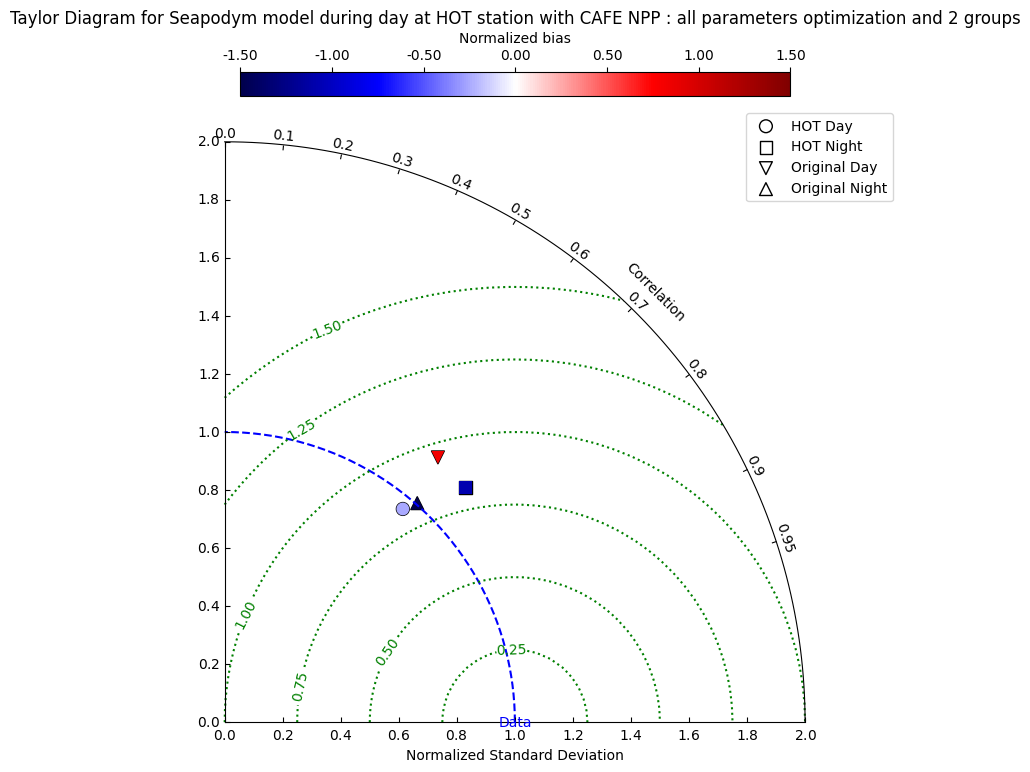

In [56]:
diagram = ModTaylorDiagram()

all_model = [monthly_pred_d1n1, monthly_pred_d1n1 + monthly_pred_d2n1, monthly_pred_orignal, monthly_pred_orignal]
all_obs = [monthly_obs_day, monthly_obs_night, monthly_obs_day, monthly_obs_night]

all_names = ["HOT Day", "HOT Night", "Original Day", "Original Night"]

for model, obs, name in zip(all_model, all_obs, all_names):
    diagram = generate_mod_taylor_diagram(diagram, obs=obs, model=model[obs.index], name=name)
diagram.plot()
plt.title(
    "Taylor Diagram for Seapodym model during day at HOT station with CAFE NPP : all parameters optimization and 2 groups"
)

# export the figure
if SAVE:
    plt.savefig(f"Taylor_{export_file_name}.png")

plt.show()

In [57]:
if SAVE:
    diagram.get_stats().to_csv(f"Stats_{export_file_name}.csv", index=False)
diagram.get_stats()

,name,correlation_coefficient,normalized_standard_deviation,bias,normalized_root_mean_square_deviation
0,HOT Day,0.641119,0.957476,-0.246412,0.830089
1,HOT Night,0.716292,1.158764,-1.082248,0.826261
2,Original Day,0.627195,1.171610,0.831313,0.950270
3,Original Night,0.660282,1.005006,-1.711912,0.826355


### Telagrand diagram


In [58]:
# Quantify and convert observations to mg/m2
obs_day = (
    observations_hot.day.isel(latitude=0, longitude=0, layer=0).pint.quantify().pint.to("mg/m2").pint.dequantify()
    # .resample(time="1D")
    # .interpolate("linear")
)

# Select and convert predictions to mg/m2
pred_day = (
    best_individuals_simulations.isel(latitude=0, longitude=0, functional_group=0)
    .sel(time=obs_day.time)
    .pint.quantify()
    .pint.to("mg/m2")
    .pint.dequantify()
)

# Calculate ranks for day observations
all_ranks_day = []
for time_ite in obs_day.time:
    pred_day_ite = np.sort(pred_day.sel(time=time_ite).data)
    obs_day_ite = float(obs_day.sel(time=time_ite))
    rank = np.searchsorted(pred_day_ite, obs_day_ite)
    all_ranks_day.append(rank)

# Quantify and convert night observations to mg/m2
obs_night = (
    observations_hot.night.isel(latitude=0, longitude=0, layer=0).pint.quantify().pint.to("mg/m2").pint.dequantify()
    # .resample(time="1D")
    # .interpolate("linear")
)

# Select and convert night predictions to mg/m2
pred_night = pred_day + (
    best_individuals_simulations.isel(latitude=0, longitude=0, functional_group=1)
    .sel(time=obs_night.time)
    .pint.quantify()
    .pint.to("mg/m2")
    .pint.dequantify()
)

# Calculate ranks for night observations
all_ranks_night = []
for time_ite in obs_night.time:
    pred_night_ite = np.sort(pred_night.sel(time=time_ite).data)
    obs_night_ite = float(obs_night.sel(time=time_ite))
    rank = np.searchsorted(pred_night_ite, obs_night_ite)
    all_ranks_night.append(rank)

In [59]:
fig = go.Figure()


value, count = np.unique(all_ranks_day, return_counts=True)
count = count / count.sum()
fig.add_trace(
    go.Bar(
        x=value,
        y=count,
        name="Day Ranks",
        marker_color="firebrick",
        opacity=0.75,
    )
)

value, count = np.unique(all_ranks_night, return_counts=True)
count = count / count.sum()
fig.add_trace(
    go.Bar(
        x=value,
        y=count,
        name="Night Ranks",
        marker_color="royalblue",
        opacity=0.75,
    )
)

# Update layout
fig.update_layout(
    title="Histogram of Ranks for Day and Night",
    xaxis_title="Rank",
    yaxis_title="P(Rank)",
    barmode="group",
)

fig.show()

In [60]:
if SAVE:
    fig.write_html(f"Telagrand_diagram_{export_file_name}.html")